In [1]:
import cv2
import random
import torch
import torch.nn.functional as F
import numpy as np
import albumentations as A
from augraphy import *
import matplotlib.pyplot as plt
import os
import torchvision.transforms.functional as TF
from PIL import Image
import math
from tqdm import tqdm

## pad_resize_and_shift

In [2]:
def pad_resize_and_shift(image, original_size, shift_limit=0.1, scale_min=-0.3, scale_max=0.3):
    h, w = original_size
    img_h, img_w = image.shape[:2]

    # 가로 세로 비율 맞추기
    scale_factor = random.uniform(scale_min, scale_max)
    new_w, new_h = int(img_w * (1 + scale_factor)), int(img_h * (1 + scale_factor))

    # shift 범위 계산
    max_shift_x = min(int(shift_limit * w), new_w - w)
    max_shift_y = min(int(shift_limit * h), new_h - h)
    shift_x = random.randint(-max_shift_x, max_shift_x) if max_shift_x > 0 else 0
    shift_y = random.randint(-max_shift_y, max_shift_y) if max_shift_y > 0 else 0

    # Albumentations 변환기 정의
    transform = A.Compose([
        A.Resize(new_h, new_w, interpolation=cv2.INTER_LINEAR),
        A.Affine(translate_px={"x": shift_x, "y": shift_y}, mode=cv2.BORDER_CONSTANT, cval=(255, 255, 255)),
        A.PadIfNeeded(min_height=h, min_width=w, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    ], p=1)

    # Albumentations 변환 적용
    augmented = transform(image=image)
    padded_image = augmented['image']

    # 최종 크기 맞추기
    final_image = cv2.resize(padded_image, (w, h), interpolation=cv2.INTER_LINEAR)
    return final_image

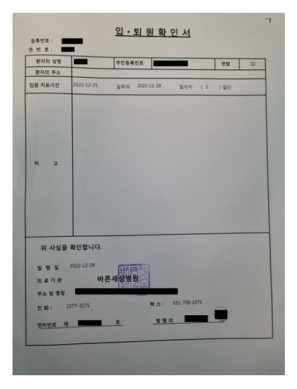

In [4]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)

# original_size 정의 
original_size = image.shape[:2]  # (height, width)

# 이전에 작성한 코드와 동일하게 이미지 변환
transformed_image = pad_resize_and_shift(image, original_size)

# BGR -> RGB로 변환
transformed_image_rgb = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)

plt.imshow(transformed_image_rgb)
plt.axis('off') 
plt.show()

## apply_rotation

In [6]:
# 로테이션 함수 정의
def apply_rotation(image, angle_min=0, angle_max=360):
    h, w = image.shape[:2]
    transform = A.Compose([
        A.Rotate(limit=(angle_min, angle_max), p=1.0, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
    ])
    transformed = transform(image=image)

    transformed_image = transformed['image']

    # 변환된 이미지를 원본 크기에 맞추고 빈 곳을 흰색으로 채우기
    padded_image = pad_resize_and_shift(transformed_image, (h, w), shift_limit=0.1, scale_min=0, scale_max=0)

    return padded_image

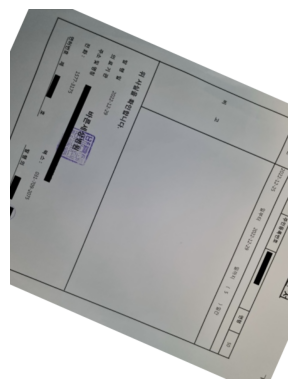

In [7]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)

rotated_image = apply_rotation(image)

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))  
plt.axis('off')  
plt.show()

## Overlay

In [8]:
# 오버레이 함수 정의
def apply_overlay(image, scale_min, scale_max, angle_min, angle_max, alpha_min, alpha_max):
    h, w = image.shape[:2]
    symmetric_image = cv2.flip(image, 1) # 1은 좌우 반전, 0은 상하 반전

    # 변환된 이미지를 원본 크기에 맞추고 빈 곳을 흰색으로 채우기
    padded_image = pad_resize_and_shift(symmetric_image, (h, w), shift_limit=0, scale_min=scale_min, scale_max=scale_max)
    # 변환된 이미지를 돌리기
    rotate_image = apply_rotation(padded_image,angle_min, angle_max)

    alpha = random.uniform(alpha_min, alpha_max) # 이 값은 오버레이할 이미지의 투명도를 결정
    overlay_image = cv2.addWeighted(image, 1, rotate_image, alpha, 0)
    return overlay_image

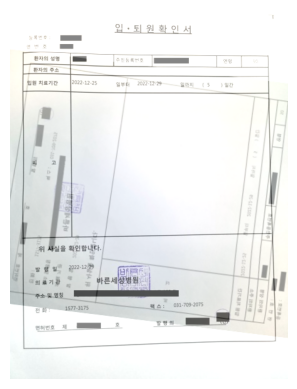

In [9]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)

# ex
scale_min = -0.3
scale_max = 0.3
angle_min = 0
angle_max = 360
alpha_min = 0.5
alpha_max = 1.0

overlay_image = apply_overlay(image, scale_min, scale_max, angle_min, angle_max, alpha_min, alpha_max)

plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  
plt.axis('off')  
plt.show()

## random_noise

In [10]:
# 노이즈 추가 함수 정의 (검정 부분 마스킹)
def add_random_noise(image_tensor, noise_range=(-0.2, 0)):
    noise_std = random.uniform(0.3, 1.0)  # 노이즈 강도 조정 (더 큰 표준 편차 선택)
    noise = torch.randn(image_tensor.size(1) // 2, image_tensor.size(2) // 2) * noise_std  # 그레이스케일 노이즈 생성 # (295, 221)
    noise = noise.unsqueeze(0).repeat(3, 1, 1)  # 채널 크기 맞추기
    noise = F.interpolate(noise.unsqueeze(0), size=(image_tensor.shape[1], image_tensor.shape[2]), mode='bilinear', align_corners=False).squeeze(0)  # 노이즈 크기를 원본 이미지에 맞게 조정 # F.interpolate 함수가 입력 텐서의 차원을 (batch_size, channels, height, width) 형태로 요구
    noise = torch.clamp(noise, noise_range[0], noise_range[1])  # 노이즈의 값 범위를 제한 (밝은 회색)

    # 검정 부분 마스킹 (RGB가 모두 0인 부분만 마스킹)
    mask = (image_tensor.sum(dim=0) != 0).float().unsqueeze(0).repeat(3, 1, 1) # 검정 부분에는 노이즈가 더해지지 않도록
    image_tensor = image_tensor + noise * mask  # 노이즈 추가
    image_tensor = torch.clamp(image_tensor, 0, 1)  # 값 범위를 0과 1 사이로 클램핑

    return image_tensor

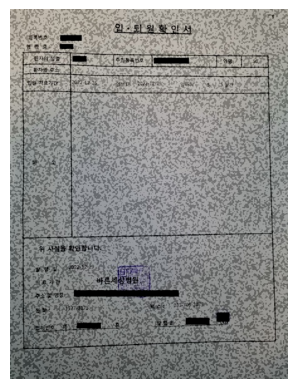

In [11]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

# 이미지 텐서로 변환하고 [0, 1] 범위로 정규화
image_tensor = torch.tensor(image / 255.0).float()  # (H, W, C) 형태의 numpy 배열을 텐서로 변환
image_tensor = image_tensor.permute(2, 0, 1)  # (C, H, W) 

noisy_image_tensor = add_random_noise(image_tensor)

# 텐서를 다시 이미지 형태로 변환
noisy_image = noisy_image_tensor.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
noisy_image = np.clip(noisy_image, 0, 1)  # 범위를 [0, 1]로 클램핑

plt.imshow(noisy_image)
plt.axis('off')  
plt.show()


## filp

In [12]:
def apply_filp(image):
    transforms = [
        A.HorizontalFlip(p=1), # 좌우반전
        A.VerticalFlip(p=1),  # 상하반전
        A.Flip(p=1),
    ]

    transform = A.Compose(random.sample(transforms, random.randint(1, len(transforms)))) # transforms에서 1~3까지 무작위 적용
    transformed = transform(image=image)

    return transformed['image']

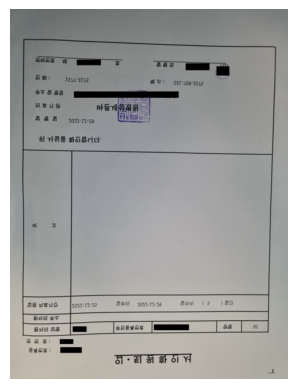

In [13]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)

rotated_image = apply_filp(image)

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))  
plt.axis('off')  
plt.show()

## 채도 감수 정의

In [14]:
# 채도 감소 함수 정의
def reduce_saturation(image, saturation_factor_range=(0.3, 0.6)):
    saturation_factor = random.uniform(*saturation_factor_range) # 채도가 1.0일 경우 원본 이미지와 같고, 0.0이면 완전히 무채색(흑백) 이미지가 됨.
    pil_image = TF.to_pil_image(image)  # numpy 배열을 PIL 이미지로 변환
    pil_image = TF.adjust_saturation(pil_image, saturation_factor)
    return np.array(pil_image)  # PIL 이미지를 numpy 배열로 변환

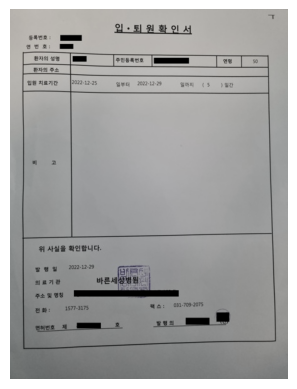

In [15]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)

rotated_image = reduce_saturation(image)

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))  
plt.axis('off')  
plt.show()

## 밝기 증가 정의

In [16]:
# 밝기 증가 함수 정의
def increase_brightness(image_tensor, brightness_increase_range=(0.1, 0.4)):
    brightness_increase = random.uniform(*brightness_increase_range)
    image_tensor = image_tensor + brightness_increase
    image_tensor = torch.clamp(image_tensor, 0, 1)
    return image_tensor

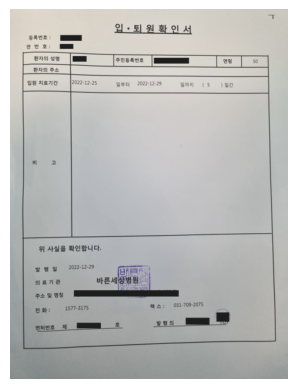

In [17]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

image_tensor = torch.tensor(image / 255.0).float()  
image_tensor = image_tensor.permute(2, 0, 1)  

noisy_image_tensor = increase_brightness(image_tensor)

noisy_image = noisy_image_tensor.permute(1, 2, 0).numpy()  
noisy_image = np.clip(noisy_image, 0, 1)  

plt.imshow(noisy_image)
plt.axis('off')  
plt.show()


## Augraphy
- 빛 번짐
- 그림자

In [18]:
# 빛 번짐 Augraphy 설정
reflected_light = ReflectedLight(
    reflected_light_smoothness=0, # 빛 번짐의 부드러움을 설정합니다. 0일 경우 경계가 뚜렷하게 나타나고, 값이 클수록 부드러운 경계를 갖게 됩니다.
    reflected_light_internal_radius_range=(0.05, 0.1),
    reflected_light_external_radius_range=(0.3, 0.3),
    reflected_light_minor_major_ratio_range=(0.9, 1.0), # 1.0이면 정원형, 0.9이면 약간 타원형
    reflected_light_color=(255, 255, 255), # 빛 번짐의 색상을 설정
    reflected_light_internal_max_brightness_range=(0.4, 0.5), # 내부 반지름에서의 최대 밝기 범위를 설정
    reflected_light_external_max_brightness_range=(0.2, 0.3), # 외부 반지름에서의 최대 밝기 범위를 설정
    reflected_light_location="random", # 빛 번짐의 위치를 무작위로 설정
    reflected_light_ellipse_angle_range=(0, 360),
    reflected_light_gaussian_kernel_size_range=(330, 330),
)

# 그림자 Augraphy 설정
shadowcast = ShadowCast(
    shadow_side="bottom",
    shadow_vertices_range=(2, 3),
    shadow_width_range=(0.5, 0.8),
    shadow_height_range=(0.5, 0.8),
    shadow_color=(0, 0, 0),
    shadow_opacity_range=(0.5, 0.6),
    shadow_iterations_range=(1, 2),
    shadow_blur_kernel_range=(101, 301),
)

## 전체 실행

In [31]:
random.seed(123)
np.random.seed(123)

In [32]:
def apply_transformations(image, num_transforms,pretrained_size=380):
    image_tensor = TF.to_tensor(image)  # 이미지 텐서로 변환
    original_size = image.shape[:2] # # 원본 이미지의 높이와 너비를 저장

    # 변환 리스트 정의
    transforms = [
        (lambda img: np.array(TF.to_pil_image(add_random_noise(TF.to_tensor(img), (-0.2, 0)))), 0.8),
        (lambda img: apply_overlay(img, scale_min=-0.3, scale_max=0.3, angle_min=0, angle_max=5, alpha_min=0.1, alpha_max=0.3), 0.9),
        (lambda img: apply_filp(img), 0.7),
        (lambda img: reduce_saturation(img), 0.7),
        (lambda img: np.array(TF.to_pil_image(increase_brightness(TF.to_tensor(img).unsqueeze(0), brightness_increase_range=(-0.1, 0.4)).squeeze(0))), 0.6),
        (lambda img: shadowcast(img), 0.3),
        (lambda img: reflected_light(img), 0.01),
        (lambda img: pad_resize_and_shift(img, original_size, shift_limit=0.1, scale_min=-0.1, scale_max=0.1), 0.2),
        (lambda img: apply_rotation(img), 0.7),
    ]

    # 변환 인덱스 선택
    indices = list(range(len(transforms)))
    selected_indices = random.sample(indices, num_transforms) if num_transforms > 0 else []

    # 변환 가중치 정의 (각 변환이 선택될 확률)
    weights = [t[1] for t in transforms]
    # 가중치를 사용 하여 num_transforms만큼 인덱스 샘플링
    selected_indices = np.random.choice(indices, size=num_transforms, replace=False, p=np.array(weights)/sum(weights))

    # 선택된 인덱스들을 강제로 순서대로 적용
    for idx in sorted(selected_indices):
        image = transforms[idx][0](image)

    # Train 이미지 크기 수정
    aug = A.Compose([
        A.LongestMaxSize(max_size=pretrained_size, always_apply=True),
        A.PadIfNeeded(min_height=pretrained_size, min_width=pretrained_size, border_mode=0, value=(255, 255, 255))
    ])

    augmented = aug(image=image)
    image = augmented['image']

    return image

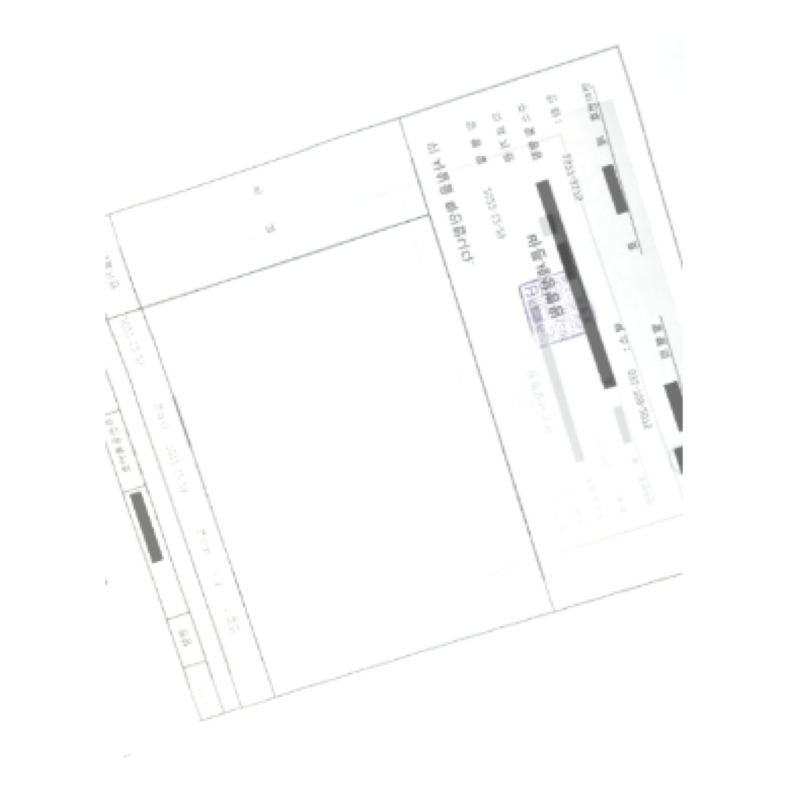

In [33]:
image_path = '/Users/seojeongmin/Desktop/Document_Type_Classification/Document-Type-Classification/example_data/0a9843bf4ec022f3.jpg'

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 변환 적용 (예: 5개의 변환을 적용)
transformed_image = apply_transformations(image, num_transforms=5)

plt.figure(figsize=(10, 10))
plt.imshow(transformed_image)
plt.axis('off') 
plt.show()

## 전체 데이터셋 적용

In [34]:
def augment_images_in_folder(input_folder, output_folder, num_augmented_images=10):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        for file in files:
            # 이미지 파일만 처리
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                input_image_path = os.path.join(root, file)
                image = cv2.imread(input_image_path)
                if image is not None:
                    for i in range(10):  # 0부터 9까지의 증강 횟수
                        num_transforms = i  # 각 증강 횟수에 맞춰 변환 개수 설정
                        transformed_image = apply_transformations(image, num_transforms,380)
                        output_image_path = os.path.join(output_folder, f"{file.rsplit('.', 1)[0]}_aug_{i+1}.jpg")
                        cv2.imwrite(output_image_path, transformed_image)

                    # 11번째 증강부터는 1~10개의 변환을 랜덤으로 적용
                    if num_augmented_images >= 10:
                        for i in range(10, num_augmented_images+1):  # 10부터 num_augmented_images까지의 증강 횟수
                            num_transforms = random.randint(1, 9)
                            transformed_image = apply_transformations(image, num_transforms,380)
                            output_image_path = os.path.join(output_folder, f"{file.rsplit('.', 1)[0]}_aug_{i+1}.jpg")
                            cv2.imwrite(output_image_path, transformed_image)

In [35]:
# input_folder = '/data/ephemeral/home/data/train'  # 원본 이미지들
# output_folder = '/data/ephemeral/home/data/aug4_20'  # 증강된 이미지들

# augment_images_in_folder(input_folder, output_folder, 20)